# A modular version

written October 2016 by Sam Greydanus

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt

import numpy as np
import gym
import tensorflow as tf

In [2]:
class Actor():
    def __init__(self, n_obs, h, n_actions):
        self.n_obs = n_obs                  # dimensionality of observations
        self.h = h                          # number of hidden layer neurons
        self.n_actions = n_actions          # number of available actions
        
        self.model = model = {}
        with tf.variable_scope('actor',reuse=False):
            # convolutional layer 1
            self.model['Wc1'] = tf.Variable(tf.truncated_normal([4, 4, 1, 16], stddev=0.1))
            self.model['bc1'] = tf.Variable(tf.constant(0.1, shape=[16]))

            # convolutional layer 2
            self.model['Wc2'] = tf.Variable(tf.truncated_normal([4, 4, 16, 16], stddev=0.1))
            self.model['bc2'] = tf.Variable(tf.constant(0.1, shape=[32]))

            # fully connected 1
            self.model['W3'] = tf.Variable(tf.truncated_normal([7 * 7 * 16, 128], stddev=0.1))
            self.model['b3'] = tf.Variable(tf.constant(0.1, shape=[128]))

            # fully connected 2
            self.model['W4'] = tf.Variable(tf.truncated_normal([128, n_obs], stddev=0.1))
            self.model['b4'] = tf.Variable(tf.constant(0.1, shape=[n_obs]))
            
    def policy_forward(self, x): #x ~ [1,D]
        x_image = tf.reshape(x, [-1, 105, 80, 1])
                                      
        zc1 = tf.nn.conv2d(x_image, self.model['Wc1'], strides=[1, 1, 1, 1], padding='SAME') + self.model['bc1']
        hc1 = tf.nn.relu(zc1)
        hc1 = tf.nn.max_pool(hc1, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME')
        
        zc2 = tf.nn.conv2d(x_image, self.model['Wc2'], strides=[1, 1, 1, 1], padding='SAME') + self.model['bc2']
        hc2 = tf.nn.relu(zc2)
        hc2 = tf.nn.max_pool(hc2, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME')
        print "hc2 shape", hc2.get_shape()
        
        hc2_flat = tf.reshape(hc2, [-1, 7*7*64])
        h3 = tf.nn.relu(tf.matmul(hc2_flat, self.model['W3']) + self.model['b3'])
        h3 = tf.nn.dropout(h3, keep_prob)
        
        h4 = tf.matmul(h3, self.model['W4']) + self.model['b4']
        return tf.nn.softmax(h4)

In [3]:
class Agent():
    def __init__(self, n_obs, n_actions, gamma=0.99, actor_lr = 1e-4, decay=0.95, epsilon = 0.1):
        self.gamma = gamma            # discount factor for reward
        self.epsilon = epsilon
        self.global_step = 0
        self.xs, self.rs, self.ys = [],[],[]
        
        self.actor_lr = actor_lr               # learning rate for policy
        self.decay = decay
        self.n_obs = n_obs                     # dimensionality of observations
        self.n_actions = n_actions             # number of available actions
        self.save_path ='models/pong.ckpt'
        
        # make actor part of brain
        self.actor = Actor(n_obs=self.n_obs, h=200, n_actions=self.n_actions)
        
        #placeholders
        self.x = tf.placeholder(dtype=tf.float32, shape=[None, n_obs],name="x")
        self.y = tf.placeholder(dtype=tf.float32, shape=[None, n_actions],name="y")
        self.r = tf.placeholder(dtype=tf.float32, shape=[None,1], name="r")
        
        #gradient processing (PG magic)
        self.discounted_r = self.discount_rewards(self.r, self.gamma)
        mean, variance= tf.nn.moments(self.discounted_r, [0], shift=None, name="reward_moments")
        self.discounted_r -= mean
        self.discounted_r /= tf.sqrt(variance + 1e-6)
        
        # initialize tf graph
        self.aprob = self.actor.policy_forward(self.x)
        self.loss = tf.nn.l2_loss(self.y-self.aprob)
        self.optimizer = tf.train.RMSPropOptimizer(self.actor_lr, decay=self.decay)
        self.grads = self.optimizer.compute_gradients(self.loss, \
                                    var_list=tf.trainable_variables(), grad_loss=self.discounted_r)
        self.train_op = self.optimizer.apply_gradients(self.grads)

        self.sess = tf.InteractiveSession()
        tf.initialize_all_variables().run()
        self.saver = tf.train.Saver(tf.all_variables())
    
    def act(self, x):
        feed = {self.x: x}
        aprob = self.sess.run(self.aprob, feed) ; aprob = aprob[0,:]
        action = np.random.choice(self.n_actions,p=aprob) if np.random.rand() > self.epsilon else np.random.randint(self.n_actions)
        
        label = np.zeros_like(aprob) ; label[action] = 1
        self.xs.append(x)
        self.ys.append(label)
        
        return action
    
    def learn(self):
        epx = np.vstack(self.xs)
        epr = np.vstack(self.rs)
        epy = np.vstack(self.ys)
        self.xs, self.rs, self.ys = [],[],[] # reset game history
        
        feed = {self.x: epx, self.r: epr, self.y: epy}
        _ = self.sess.run(self.train_op,feed) # parameter update
        self.global_step += 1
        
    def try_load_model(self):
        load_was_success = True # yes, I'm being optimistic
        try:
            save_dir = '/'.join(self.save_path.split('/')[:-1])
            ckpt = tf.train.get_checkpoint_state(save_dir)
            load_path = ckpt.model_checkpoint_path
            self.saver.restore(self.sess, load_path)
        except:
            print "no saved model to load. starting new session"
            load_was_success = False
        else:
            print "loaded model: {}".format(load_path)
            self.saver = tf.train.Saver(tf.all_variables())
            self.global_step = int(load_path.split('-')[-1])
            
    def save(self):
        self.saver.save(self.sess, self.save_path, global_step=self.global_step)
        
    @staticmethod
    def discount_rewards(r, gamma):
        discount_f = lambda a, v: a*gamma + v;
        r_reverse = tf.scan(discount_f, tf.reverse(r,[True, False]))
        discounted_r = tf.reverse(r_reverse,[True, False])
        return discounted_r

In [4]:
# downsampling
def prepro(o):
    rgb = o[:200,:150]
    gray = 0.3*rgb[:,:,0] + 0.4*rgb[:,:,1] + 0.3*rgb[:,:,2]
    gray = gray[::2,::2]
    gray -= np.mean(gray) ; gray /= 100
    return gray.astype(np.float).ravel()

def plt_dynamic(x, y, ax, colors=['b']):
    for color in colors:
        ax.plot(x, y, color)
    fig.canvas.draw()

In [5]:
n_obs = 2*75*100   # dimensionality of observations
n_actions = 3
agent = Agent(n_obs, n_actions, gamma = 0.99, actor_lr=5e-4, decay=0.99, epsilon = 0.1)
# agent.try_load_model()

env = gym.make("Pong-v0")
observation = env.reset()
cur_x = None
running_reward = -20.48 # usually starts around 10 for cartpole
reward_sum = 0
episode_number = agent.global_step

[2016-10-21 15:44:47,854] Making new env: Pong-v0


<IPython.core.display.Javascript object>


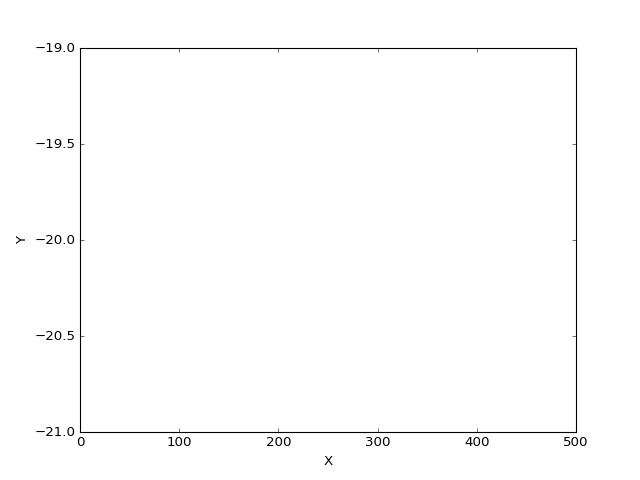

episode 0: starting up...
ep: 0, reward: -20.0, mean reward: -20.475200
	ep: 1, reward: -21.0
	[ 0.01989374  0.04274382  0.93736243]
	ep: 2, reward: -21.0
	[ 0.01566052  0.03192243  0.95241714]
	ep: 3, reward: -21.0
	[ 0.01889256  0.04376131  0.93734616]


KeyboardInterrupt: 

In [6]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('X') ; ax.set_ylabel('Y')
ax.set_xlim(0,500) ; ax.set_ylim(-21,-19)
pxs, pys = [], []

print 'episode {}: starting up...'.format(episode_number)
while True:
#     if episode_number%25==0: env.render()

    # preprocess the observation, set input to network to be difference image
    prev_x = cur_x if cur_x is not None else np.zeros(n_obs/2)
    cur_x = prepro(observation)
    x = np.concatenate((cur_x, prev_x))

    # stochastically sample a policy from the network
    action = agent.act(np.reshape(x, (1,-1)))

    # step the environment and get new measurements
    observation, reward, done, info = env.step(action + 1)
    agent.rs.append(reward)
    reward_sum += reward
    
    if done:
        running_reward = running_reward * 0.99 + reward_sum * 0.01
        agent.learn()

        # visualization
        pxs.append(episode_number)
        pys.append(running_reward)
        if episode_number % 10 == 0:
            print 'ep: {}, reward: {}, mean reward: {:3f}'.format(episode_number, reward_sum, running_reward)
            plt_dynamic(pxs, pys, ax)
        else:
            print '\tep: {}, reward: {}'.format(episode_number, reward_sum)
            feed = {agent.x: np.reshape(x, (1,-1))}
            aprob = agent.sess.run(agent.aprob, feed) ; aprob = aprob[0,:]
            print'\t', aprob
            
#         if episode_number % 50 == 0: agent.save() ; print "SAVED MODEL #{}".format(agent.global_step)
        
        # lame stuff
        cur_x = None
        episode_number += 1 # the Next Episode
        observation = env.reset() # reset env
        reward_sum = 0

In [7]:
%matplotlib inline
# plt.imshow(observation)
print prepro(observation)[:-100]

[-0.90704213 -0.90704213 -0.90704213 ...,  1.45295787  1.45295787
  1.45295787]


In [8]:
print observation.shape

(210, 160, 3)
